# Getting Started with floras
Floras is a tool for flow-based test environment synthesis. Every test is defined using a system model, a system objective, and a test objective. Floras then sets up and solves a mixed-integer linear program (MILP) that ensures that every test execution that satisfies the system objective will also satisfy the test objective.

To follow along, please install floras according to the instructions in *[Installing](https://floras.readthedocs.io/en/latest/installing/)*.

## System Model
The system model is a labeled transition system, consisting of the states, transitions, labels, and initial state of the system.
We can set up this system model by defining the states and transitions explicitly, or if the problem is a grid world, we can use a text file that sets up this grid world.

Let's set up the following problem:
<div style="text-align:center"><img src="https://github.com/jgraeb/floras/blob/main/docs/imgs/medium_grid.png?raw=true" width=300></div>

The system starts in the cell labeled $S$ (magenta), the terminal states are labeled $T$ (yellow), and in addition some cells are labeled $I$ (blue).

We can set up this transition system in the following way:

In [1]:
from floras.components.transition_system import TransitionSystemInput, TranSys

rows = 3; cols = 5

# defining the state for each cell on the grid
states_list = [(i, j) for i in range(0, rows) for j in range(0, cols)]

# defining the transitions from each cell on the grid
transitions_dict = {}
for i in range(rows):
        for j in range(cols):
            cell = (i, j)
            neighbors = [
                (i + di, j + dj) for di, dj in 
                [(-1, 0), (1, 0), (0, -1), (0, 1), (0, 0)]
                if 0 <= i + di < rows and 0 <= j + dj < cols
            ]
            transitions_dict[cell] = neighbors

# defining the labeled states
labels_dict = {
    (2, 0): ['I'], (0, 2): ['I'], (2, 4): ['I'], 
    (0, 0): ['T'], (0, 4): ['T'], (2, 2): ['S']
}

# defining the initial state
init_list = [(2, 2)]

# creating the transition system input
transition_system_input = TransitionSystemInput(
    states_list, transitions_dict, labels_dict, init_list
)

# get transition system
transys = TranSys(transition_system_input)

We can simplify this code by using a text file for the grid layout. This text file consists of lines of text, with the character ```|``` at the end of each line. Every space corresponds to a grid cell, where ``` ``` is a normal grid cell, and ```*``` corresponds to a blocked cell that cannot be occupied by the system.

For our example, the text file will represent an empty grid with dimensions $3x5$:
```
     |
     |
     |
```
This is saved in a file named *gridworld.txt*. We can then use the follwing function to automatically generate the states and transitions.

In [2]:
from floras.components.utils import get_states_and_transitions_from_file

gridfile = "gridworld.txt"
states_list, transitions_dict = get_states_and_transitions_from_file(gridfile)

Followed by defining the desired labels and initial states as illustrated above.

## System Objective
The system objective is an LTL specification consisting of at least one reachability sub-task, and optional safety and reaction sub-tasks. Given atomic propositions $p$ and $q$, that are true in the corresponding system states, the sub-tasks are given according to the following patterns:

| Sub-task    | LTL Formula | Description |
| -------- | ------- | --------|
| Reachability  | $\lozenge p$    | *eventually $p$*|
| Sequenced Reachability | $\lozenge (p \land \lozenge q)$ | *eventually $p$ and then eventually $q$*|
| Safety    | $\square p$    | *always $p$* |
| Delayed Reaction | $p \rightarrow \lozenge q$| *p implies eventually $q$* |
| Instantaneous Reaction | $p \rightarrow q$| *p implies $q$* |

Each system objective can be a conjuncton of multiple sub-tasks, including a reachability sub-task to the terminal state of the system.

For the example problem, let's set up the system objective $\varphi_{\text{sys}}= \lozenge T$. We can use the notation 'F' or '<>' to represent the eventually temporal operator.

In [3]:
from floras.components.automata import get_system_automaton

sys_formula = 'F(T)'  # 'F(T)' or '<> T' for 'eventually T'
sys_aut, spot_aut_sys = get_system_automaton(sys_formula)

The output 'sys_aut' is shown in the image below. It is the automaton corresponding to the system objective $\lozenge T$, and the accepting state ($q_0$) is highlighted in yellow.
<div style="text-align:center"><img src="https://github.com/jgraeb/floras/blob/main/docs/imgs/sys_aut.png?raw=true" width=100></div>

## Test Objective
The test objective consists of one or more reachability tasks, or sequenced reachability tasks.

| Sub-task   | LTL Formula | Description |
| -------- | ------- | --------|
| Reachability  | $\lozenge p$    | *eventually $p$*|
| Sequenced Reachability | $\lozenge (p \land \lozenge q)$ | *eventually $p$ and then eventually $q$*|

For our example, the test objective is $\varphi_{\text{test}} = \lozenge I$.

In [4]:
from floras.components.automata import get_tester_automaton

test_formula = 'F(I)'
test_aut, spot_aut_test = get_tester_automaton(test_formula)

The output 'test_aut' is the automaton corresponding to the test objective, and is shown in the image below. The accepting state ($q_0$) is highlighted in blue. Note that the system and test objective automata states are labeled similarly but correspond to different states.

<div style="text-align:center"><img src="https://github.com/jgraeb/floras/blob/main/docs/imgs/test_aut.png?raw=true" width=100></div>

## Constructing the Virtual Graphs

### Constructing the Specification Automaton
First, we construct the specification automaton of the system and test objectives. This is a custom definition, and the resulting automaton now captures the event-based progression of the test.

In [5]:
from floras.components.automata import get_product_automaton

prod_aut = get_product_automaton(spot_aut_sys, spot_aut_test)

The resulting specification product is shown in the following image. The system objective accepting states are highlighted in yellow and the states that are accepting for the test objective (but not the system objective) are highlighted in blue.

<div style="text-align:center"><img src="https://github.com/jgraeb/floras/blob/main/docs/imgs/prod_aut.png?raw=true" width=200></div>

### Constructing the Virtual Graphs
Once we have the specification product, we now create the virtual product graph and the virtual system graph. These graphs now contain the information from the transition system and correspond to the test executions that are physically possible for the system to take and how they correspond to the system and test objectives.

In [6]:
from floras.components.product import sync_prod

# get virtual graphs
virtual_sys = sync_prod(transys, sys_aut)
virtual = sync_prod(transys, prod_aut)

## Solving the Mixed-Integer Linear Program (MILP)

Using these graphs, we can now set up the MILP to solve the test environment synthesis problem as follows. For this example, we want the restictions to be static obstacles on the grid, therefore we chose the *static* case.

In [7]:
from floras.optimization.optimize import solve

d, flow = solve(virtual, transys, prod_aut, virtual_sys, case='static')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-21
Set parameter Seed to value 92
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1558 rows, 345 columns and 2538 nonzeros
Model fingerprint: 0x240b4dbc
Variable types: 191 continuous, 154 integer (154 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1471 rows and 266 columns
Presolve time: 0.00s
Presolved: 87 rows, 79 columns, 258 nonzeros
Variable types: 64 continuous, 15 integer (15 binary)
Found heuristic solution: objective 1.8181818

Root relaxation: objective 2.824675e+00, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Boun

The resulting restrictions are captured in the output variable 'd', and they translate to static obstacles on the grid world. 
The output 'flow' captures the number of unique paths that exist on the virtual graph from the initial position to the system objective accepting state that pass through the test objective accepting states. In this example we have a flow of $3$, which corresponds to three different unique paths through the virtual graph.

The cuts on the virtual product graph correspond to restricting the red dashed edges in this figure:

<div style="text-align:center"><img src="https://github.com/jgraeb/floras/blob/main/docs/imgs/medium_virtual_w_cuts.png?raw=true" width=700></div>

Which also correspond to the following restrictions on the grid:

<div style="text-align:center"><img src="https://github.com/jgraeb/floras/blob/main/docs/imgs/medium_result.png?raw=true" width="300"/></div>

With these restrictions we can see that every successful system execution (reaching $T$), has to pass through one of the states labeled $I$ before arriving at $T$.


## From a json File

Instead of the code above, we can also define the problem in a json file. We can define the system model using the keywords "mazefile" (or "states" and "transitions"), "init", "goals", and "labels".

The system objective is given in "sysformula" and the test objective is given in "testformula". The type of problem is defined to be static (as opposed to reactive).

This is defined in the following json file *example.json*.

```
{
      "mazefile" : "gridworld.txt",
      "init" : ["(2, 2)"],
      "goals" : ["(0, 0)", "(0, 4)"],
      "labels" : {
        "(0,2)": ["I"],
        "(2,0)": ["I"],
        "(2,4)": ["I"],
        "(0,0)": ["T"],
        "(0,4)": ["T"]
      },
      "sysformula" : "F(T)",
      "testformula" : "F(I)",
      "type": "static"

}
```
The problem can now be solved by running the following small script, which prints the output to the terminal.

In [8]:
from floras.main import find_test_environment

filename = 'example.json'
d, flow = find_test_environment(filename)

Set parameter Seed to value 25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1558 rows, 345 columns and 2538 nonzeros
Model fingerprint: 0xcea83b20
Variable types: 191 continuous, 154 integer (154 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1471 rows and 266 columns
Presolve time: 0.00s
Presolved: 87 rows, 79 columns, 258 nonzeros
Variable types: 64 continuous, 15 integer (15 binary)
Found heuristic solution: objective 1.8181818
Found heuristic solution: objective 1.8441558

Root relaxation: objective 2.824675e+00, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

You can also call floras directly from the command line using a json file by running 
```from_json --filename example.json```
from the command line. This will print the output to the terminal.

The solution to this problem is not unique, if you want to plot the result you can run the following code:

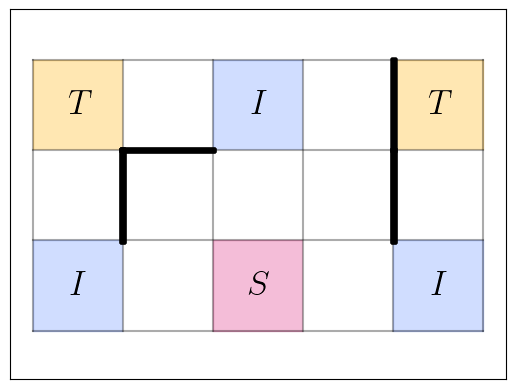

In [9]:
from floras.components.grid import Grid
from floras.components.plotting import plot_grid

# Set up to plot the result
colors_dict = {
    (0, 0): '#ffb000', (0, 4): '#ffb000', (2, 0): '#648fff',
    (0, 2): '#648fff', (2, 4): '#648fff', (2, 2): '#dc267f'
}
gridfile = "gridworld.txt"
grid = Grid(gridfile, labels_dict, colors_dict)
obstacles = [(cut[0][0], cut[1][0]) for cut in d]

# plot and save the result
resultfile = 'resultfile'
plot_grid(grid, resultfile, obstacles)

### References

Baier, Christel, and Joost-Pieter Katoen. *Principles of model checking.* MIT press, 2008.

[Josefine B. Graebener\*, Apurva S. Badithela\*, Denizalp Goktas, Wyatt Ubellacker, Eric V. Mazumdar, Aaron D. Ames, and Richard M. Murray. *Flow-Based Synthesis of Reactive Tests for Discrete Decision-Making Systems with Temporal Logic Specifications.* ArXiv abs/2404.09888, 2024.](https://arxiv.org/abs/2404.09888)
